# Smiles used in training with energy = 50log(100 + mmff_energy): 
"Brc1cc2c(cc1Cn1c(-c3cncs3)nc3ccccc31)OCO2" (n = 3) 
"Brc1ccc(-c2nc(NN=Cc3cccnc3)c3ccccc3n2)cc1" (n = 5)
"C(=NNc1nc(Nc2ccccc2)nc(N2CCOCC2)n1)c1c[nH]c2ccccc12" (n = 7)

In [1]:
import pickle
from diffusion.sampling import *
from diffusion.likelihood import mmff_energy
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit import Chem, Geometry
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolAlign 
from termcolor import colored 
from rdkit.Chem import rdMolTransforms
from utils.standardization import fast_rmsd
from torch_geometric.data import Data, Batch
from scipy.stats import multivariate_normal
import tqdm

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [5]:
import numpy as np
(np.log(5) - np.log(3)).item()

0.5108256237659905

In [2]:
def get_bond_lengths(mol):
    assert mol.GetNumConformers() == 1
    bond_lengths = []
    for bond in mol.GetBonds():
        bond_lengths.append(rdMolTransforms.GetBondLength(mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() ) )
    return torch.Tensor(bond_lengths)

def get_bond_angles(mol):
    assert mol.GetNumConformers() == 1
    bond_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                angle = rdMolTransforms.GetAngleRad(mol.GetConformer(),   
                                                    atom1.GetIdx(), 
                                                    atom2.GetIdx(), 
                                                    neighbor.GetIdx())
                bond_angles.append(angle)
    return torch.Tensor(bond_angles)

def get_torsion_angles(mol):
    assert mol.GetNumConformers() == 1
    torsion_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor1 in atom2.GetNeighbors():
            if neighbor1.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                for neighbor2 in neighbor1.GetNeighbors():
                    if neighbor2.GetIdx() != atom2.GetIdx() and neighbor2.GetIdx() != atom1.GetIdx():
                        torsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(), 
                                                                 atom1.GetIdx(), 
                                                                 atom2.GetIdx(), 
                                                                 neighbor1.GetIdx(), 
                                                                 neighbor2.GetIdx())
                        torsion_angles.append(torsion)
    return torch.Tensor(torsion_angles)

def get_stds_internal_coords(mols):
    
    all_bond_lengths = [get_bond_lengths(mol) for mol in mols]
    all_bond_angles = [get_bond_angles(mol) for mol in mols]
    all_torsion_angles = [get_torsion_angles(mol) for mol in mols]
    bond_lengths_std = torch.stack(all_bond_lengths).std(dim=0).mean()
    bond_angles_std = torch.stack(all_bond_angles).std(dim=0).mean()
    torsion_angles_std = torch.stack(all_torsion_angles).std(dim=0).mean()
    return bond_lengths_std, bond_angles_std, torsion_angles_std

def get_rmsds(mols, mols_optimized):
    '''
    This function compares a set of molecules with their optimized versions and returns the RMSDs between each pair (non-optimized, optimized).
    '''
    rmsds = []
    for conf_idx in range(len(mols)):
        mol0, mol1 = mols[conf_idx], mols_optimized[conf_idx]
        rdMolAlign.AlignMol(mol0, mol1)
        rmsds.append(fast_rmsd(mol0, mol1 , conf1=0, conf2=0) )
    return rmsds 



In [3]:
def plot_aligned_confs(data):
    mols = []
    for conf in data:
        mol = pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True)
        mols.append(mol)
    # align all mols to the first one
    for i in range(1, len(mols)):
        rdMolAlign.AlignMol(mols[i], mols[0])
    # Plot mols
    ## Convert to mol blocks
    mol_blocks = [Chem.MolToMolBlock(mol) for mol in mols]

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'pink', 'brown', 'grey', 'black', 'white', 'salmon', 'olive', 'lime', 'teal', 'indigo', 'violet', 'tan', 'khaki', 'gold', 'coral', 'azure', 'lavender', 'orchid', 'plum', 'crimson', 'maroon', 'sienna', 'navy', 'skyblue', 'turquoise', 'aquamarine', 'mint', 'lime', 'chartreuse', 'olive', 'khaki', 'gold', 'coral', 'salmon', 'tomato', 'orangered', 'firebrick', 'maroon', 'sienna', 'chocolate', 'saddlebrown', 'brown', 'black', 'grey', 'dimgray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'white']
    view = py3Dmol.view(width=400, height=400)
    for i, mol_block in enumerate(mol_blocks):
        view.addModel(mol_block, "mol")
        view.setStyle({'model': i}, {'stick': {'color': colors[i%len(colors)]}})

    view.addLabel('confs',{'position': {'x': 0, 'y': 8, 'z': 0}, 
                'backgroundColor': 'white', 
                'fontColor': 'black', 
                'fontSize': 16, 
                'alignment': 'topCenter'})
    view.zoomTo()
    view.show()

In [4]:
def get_2dheatmap_array(data,ix0, ix1, num_points):
    '''
    Get 2Denergy heatmap. This is obtained by computing the energy for different value (linspace) of the 2 torsion angles ix0 and ix1. 
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, num_points)
    mols_energy_landscape = []
    for theta0 in torsion_angles_linspace:
        mols_energy_landscape.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mols_energy_landscape[-1].append(mol)
    energy_landscape = [[mmff_energy(mol) for mol in mols] for mols in mols_energy_landscape]
    #print('energies (1st row)', energy_landscape[0])
    return energy_landscape
    

In [5]:
def get_rmsd_torsiondist(data,ix0, ix1):
    '''
    Get 2D rmsd heatmap and 2D torsion_angles dists heatmap
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, 100)
    rmsds = []
    torsion_angles_dists = []
    for theta0 in torsion_angles_linspace:
        rmsds.append([])
        torsion_angles_dists.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol0 = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
            rmsds[-1].append(fast_rmsd(mol0, mol, conf1=0, conf2=0))
            torsion_angles_dists[-1].append(min(theta1, 2 * np.pi - theta1) + min(theta0, 2 * np.pi - theta0))  
            
    return rmsds, torsion_angles_dists

## Understanding relaxation

In [5]:
# load conformers_20steps.pkl
#conformers_train = pickle.load(open('true_conformers_train_1smiles.pkl', 'rb'))
conformers_train = None
conformers_gen = pickle.load(open('conformers_20steps_train_1smiles.pkl', 'rb'))
conformers_optimized = pickle.load(open('conformers_20steps_train_1smiles_optimized.pkl', 'rb'))
smis = list(conformers_gen.keys())

In [17]:
for i, smile in enumerate(smis): 
    #Plt figure with 2 subfigures
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    #mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    mols_train, mols_gen, mols_optimized = conformers_train, conformers_gen[smile], conformers_optimized[smile]
    #Plot the hists in the first subfigure
    #ax[0].hist([mmff_energy(mol) for mol in mols_train], bins=20, color = 'blue', label='train', alpha=0.25  )
    ax[0].hist([mmff_energy(mol) for mol in mols_gen], bins=20, color = 'orange',label='gen', alpha=0.25)
    ax[0].hist([mmff_energy(mol) for mol in mols_optimized], bins=20, color = 'green',label='gen_optimized', alpha=0.25)
    ax[0].legend()
    ax[0].set_xscale('log')
    ax[0].set_title(f'Energy distribution')
    # Plot the RMSD in the second subfigure
    rmsds = get_rmsds(mols_gen, mols_optimized)
    ax[1].boxplot(rmsds)
    ax[1].set_title(f'RMSD(gen, optimized)')
    # add title to the whole figure
    fig.suptitle(f'Mol {i}, smile {smile}')
    #Add title for the whole figure
    i+=1
    #if i ==1:
        #break


NameError: name 'smis' is not defined

Text(0.5, 1.0, 'RMSD')

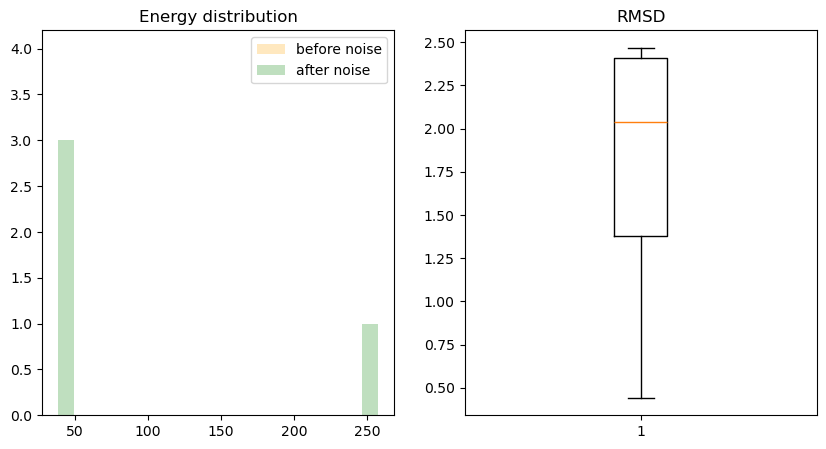

In [12]:
samples_before_perturb = pickle.load(open('samples_before_perturb.pkl', 'rb'))
samples_after_perturb = pickle.load(open('samples_after_perturb.pkl', 'rb'))
#Plt figure with 2 subfigures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#Plot the hists in the first subfigure
ax[0].hist([mmff_energy(x.mol) for x in samples_before_perturb], bins=20, color = 'orange',label='before noise', alpha=0.25)
ax[0].hist([mmff_energy(x.mol) for x in samples_after_perturb], bins=20, color = 'green',label='after noise', alpha=0.25)
ax[0].legend()
ax[0].set_title(f'Energy distribution')
# Plot the RMSD in the second subfigure
rmsds = get_rmsds([x.mol for x in samples_before_perturb], [x.mol for x in samples_after_perturb])
ax[1].boxplot(rmsds)
ax[1].set_title(f'RMSD')


In [6]:
ix = 0
mol0 = conformers_gen[smis[0]][ix]
mol1 = samples_before_perturb[ix].mol
mol2 = samples_after_perturb[ix].mol
rdMolAlign.AlignMol(mol0, mol1)
rdMolAlign.AlignMol(mol2, mol1)
# Convert to mol blocks
mol0_block = Chem.MolToMolBlock(mol0)
mol1_block = Chem.MolToMolBlock(mol1)
mol2_block = Chem.MolToMolBlock(mol2)

view = py3Dmol.view(width=400, height=400)
view.addModel(mol0_block, "mol")
view.addModel(mol1_block, "mol")
view.addModel(mol2_block, "mol")
view.setStyle({'model': 0}, {'stick': {'color': 'green'}})
view.setStyle({'model': 1}, {'stick': {'color': 'red'}})
view.setStyle({'model': 2}, {'stick': {'color': 'blue'}})
view.addLabel('Gen (green) || Before (red) after (blue) noising}',{'position': {'x': 0, 'y': 8, 'z': 0}, 
               'backgroundColor': 'white', 
               'fontColor': 'black', 
               'fontSize': 16, 
               'alignment': 'topCenter'})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Let's look at the internal coordinate differences before vs after relaxation, for bond lengths, bond angles and torsion angles:

In [7]:
for smile in smis:
    print(f'MOL={smile}')
    bond_lengths_diffs = 0
    bond_angles_diffs = 0
    torsion_angles_diffs = 0
    mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    for conf_idx in range(len(mols_train)):
        mol1, mol2 =mols_gen[conf_idx], mols_optimized[conf_idx]
        bond_lengths_diff, bond_angles_diff, torsion_angles_diff = get_stds_internal_coords([mol1, mol2])
        bond_lengths_diffs +=bond_lengths_diff
        bond_angles_diffs +=bond_angles_diff
        torsion_angles_diffs += torsion_angles_diff
    print(f'Mean Bond length std: {bond_lengths_diffs/len(mols_train):.2f} Å, Mean Bond angles std: {bond_angles_diffs/len(mols_train):.2f} rad, Mean Torsion angles std: {torsion_angles_diffs/len(mols_train):.2f} rad' )


MOL=COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.32 rad
MOL=S=C(NCc1ccc2c(c1)OCO2)NC1CC1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.04 rad
MOL=CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.06 rad, Mean Torsion angles diff: 1.06 rad
MOL=Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1
Mean Bond length diff: 0.04 Å, Mean Bond angles diff: 0.09 rad, Mean Torsion angles diff: 1.40 rad
MOL=CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.27 rad
MOL=CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.11 rad
MOL=[NH3+]CCCP(=O)(O)CCc1ccccc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.05 rad, Mean Torsion angles diff: 1.19 rad
MOL=Cc1c

Hmmmm, interesting, the torsion angles change a lot with relaxation. But why does relaxation need to go so far in terms of RMSD? Why doesn't it go to the closest 'ground-truth' conformer?

Well, if we look at the eval metrics for this set of molecules: 

 - threshold 0.75:

- Recall Coverage: Mean = 61.66, Median = 82.02

- Recall AMR: Mean = 0.6300, Median = 0.5793

- Precision Coverage: Mean = 35.80, Median = 42.31

- Precision AMR: Mean = 0.9013, Median = 0.7905

The precision AMR is around 0.9, i.e. it is the same order of magnitude of relaxtion. So the results with relaxation are not that surprising

**Training conformers after conformer matching have low energy!** Ca laisse penser que c'est le modele qui est pas assez bon

        - Plot : bond lengths and angles distribution of training conformers after confs matching. Ot has very low variance, so it makes sense to fix bond lengths/angles, and it's the diff model that is pretty bad
       
        - How does this energy compare to the energy of conformers **before confs matching?** -> voir si ça vaut vraiment le coup de fixer les bond lengths/angles ou pas

## Dataset Exploration

In [6]:
from utils.dataset import *
from utils.featurization import dihedral_pattern, featurize_mol, qm9_types, drugs_types

data_dir='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/drugs/'
split_path='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/split_boltz_10k.npy'
mode = 'train'
dataset='drugs'
#transform = TorsionNoiseTransform(sigma_min=0.01*3.14, sigma_max= 3.14,boltzmann_weight=False)
#transform = NoTransform(sigma_min=0.01*3.14, sigma_max= 3.14,boltzmann_weight=False)
transform = None
num_workers = 32
limit_molecules = 0
types = drugs_types
cache = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run'
pickle_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/standardized_pickles'
boltzmann_resampler = None

dataset = ConformerDataset(data_dir, split_path, mode, dataset,
                                   types, transform,
                                   num_workers,
                                   limit_molecules,
                                   cache,
                                   pickle_dir,
                                   boltzmann_resampler)
print(f'Number of datapoints {len(dataset.datapoints)}')
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Reusing preprocessing from cache /home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run.train
Number of datapoints 9295


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
for  ix_smi, batch in enumerate(loader):
    #if batch[0].canonical_smi == 'C(=NNc1nc(Nc2ccccc2)nc(N2CCOCC2)n1)c1c[nH]c2ccccc12':
        #break
    if len(batch[0].mask_rotate) == 7 : 
        print(ix_smi, batch[0])

19 Data(x=[33, 74], edge_index=[2, 68], edge_attr=[68, 4], z=[33], canonical_smi='C#CCN(C(=O)Nc1ccccc1)c1ccccc1', mol=<rdkit.Chem.rdchem.Mol object at 0x7f621914d820>, pos=[9], weights=[9], edge_mask=[68], mask_rotate=[7, 33])
20 Data(x=[44, 74], edge_index=[2, 94], edge_attr=[94, 4], z=[44], canonical_smi='C#CCN1C(=O)C(O)(CC(=O)c2ccc3c(c2)OCCO3)c2ccccc21', mol=<rdkit.Chem.rdchem.Mol object at 0x7f621914d970>, pos=[30], weights=[30], edge_mask=[94], mask_rotate=[7, 44])
22 Data(x=[22, 74], edge_index=[2, 44], edge_attr=[44, 4], z=[22], canonical_smi='C#CCOc1ccc(Cl)cc1C=NO', mol=<rdkit.Chem.rdchem.Mol object at 0x7f621914d970>, pos=[10], weights=[10], edge_mask=[44], mask_rotate=[7, 22])
23 Data(x=[22, 74], edge_index=[2, 44], edge_attr=[44, 4], z=[22], canonical_smi='C#CCOc1ccc(C=NO)cc1Cl', mol=<rdkit.Chem.rdchem.Mol object at 0x7f621914d890>, pos=[9], weights=[9], edge_mask=[44], mask_rotate=[7, 22])
24 Data(x=[29, 74], edge_index=[2, 60], edge_attr=[60, 4], z=[29], canonical_smi='C#C

smi: C=CCNc1cnn(CC(C)=O)c(=O)c1Br
mmff energy optimized 262.46560840627495


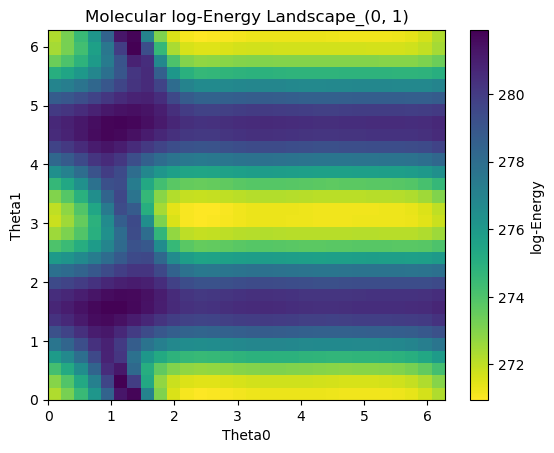

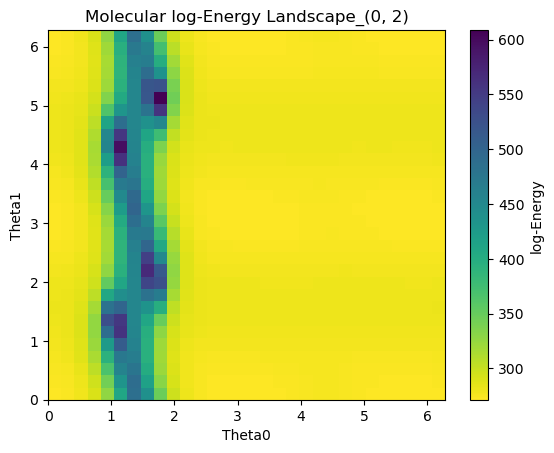

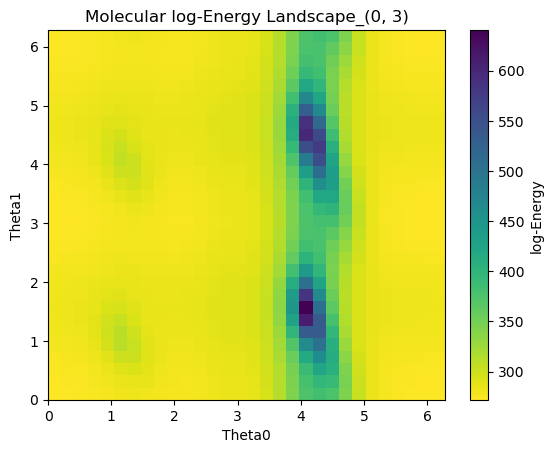

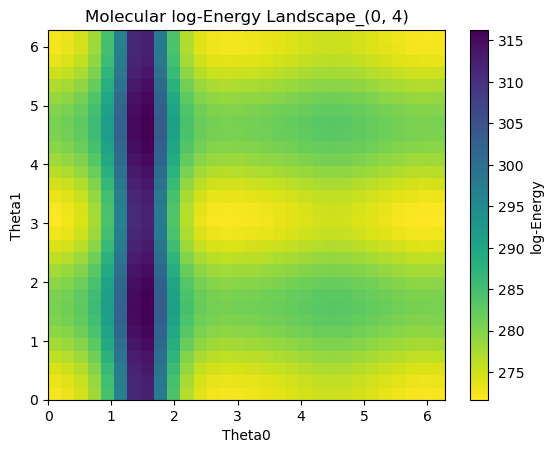

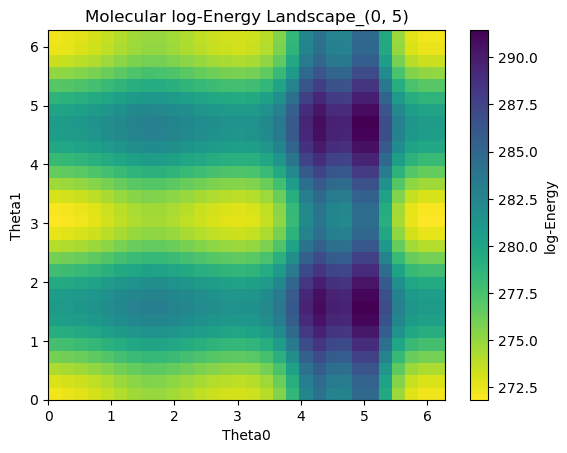

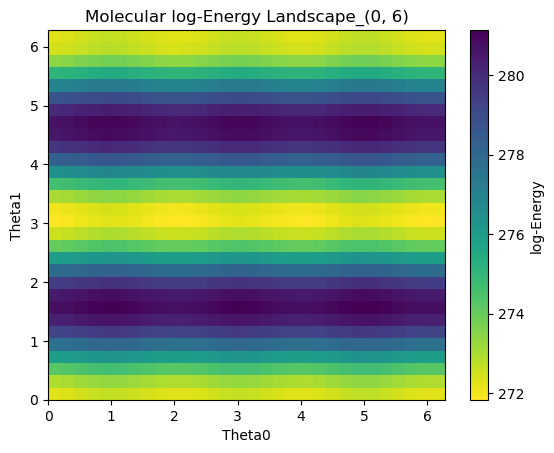

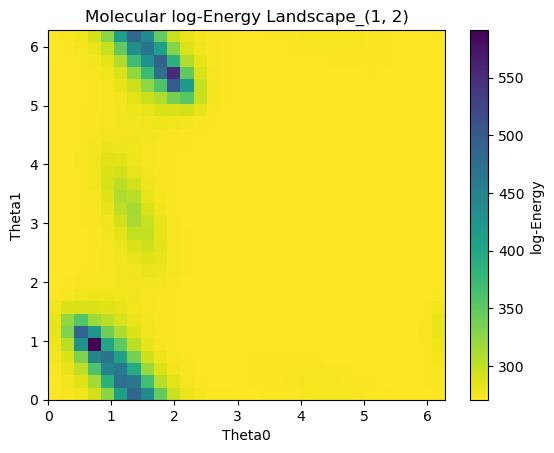

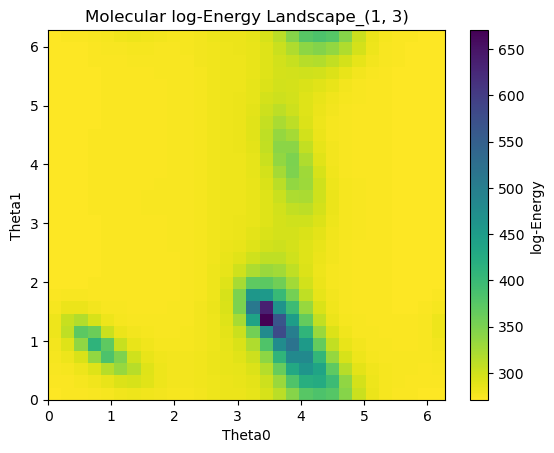

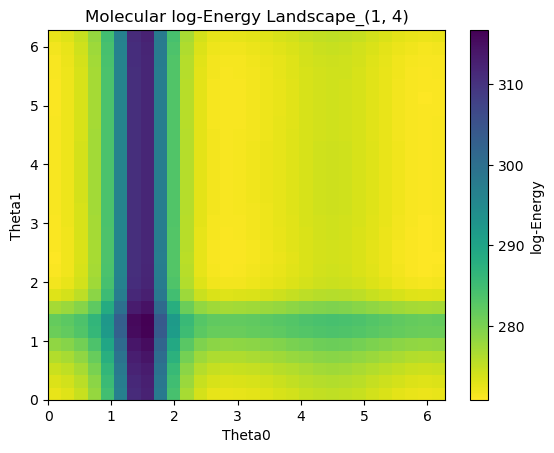

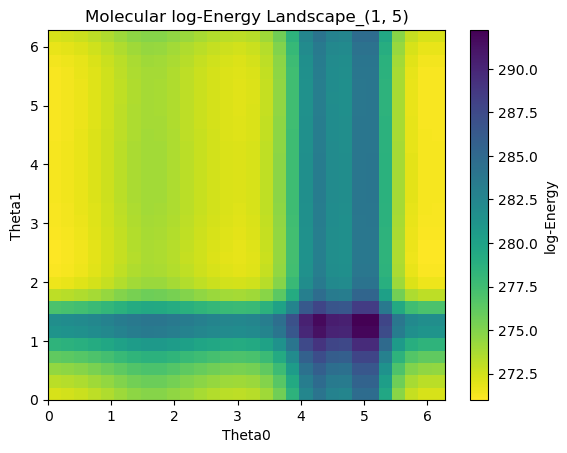

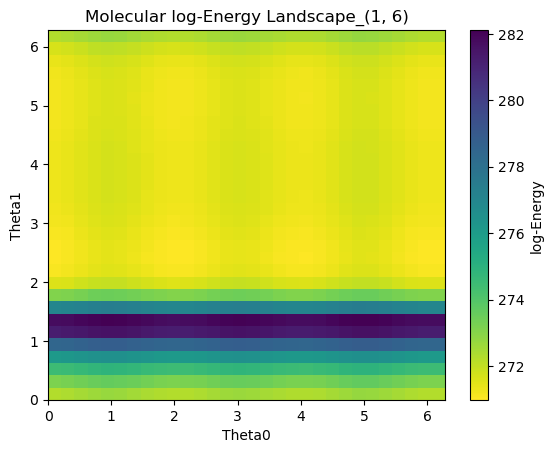

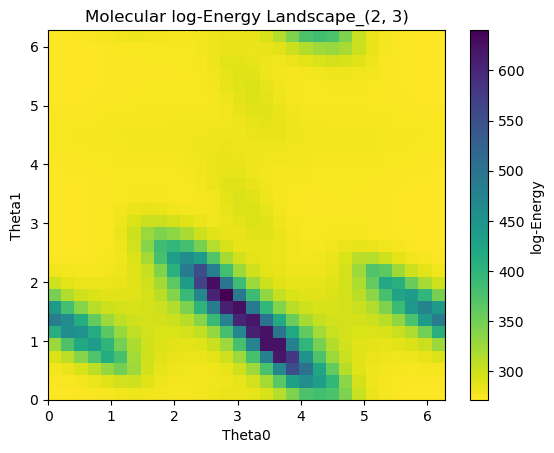

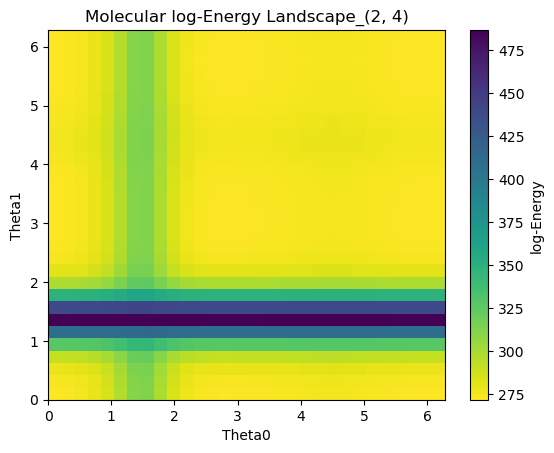

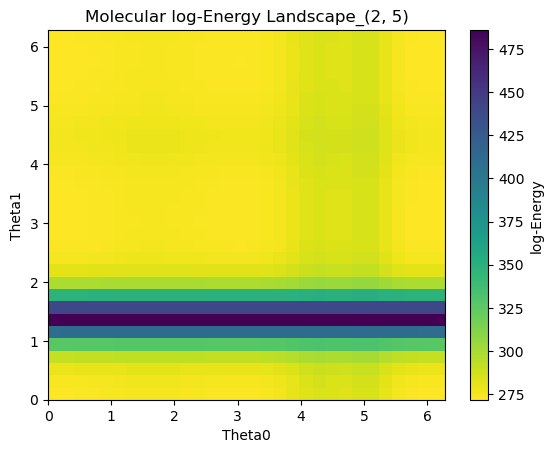

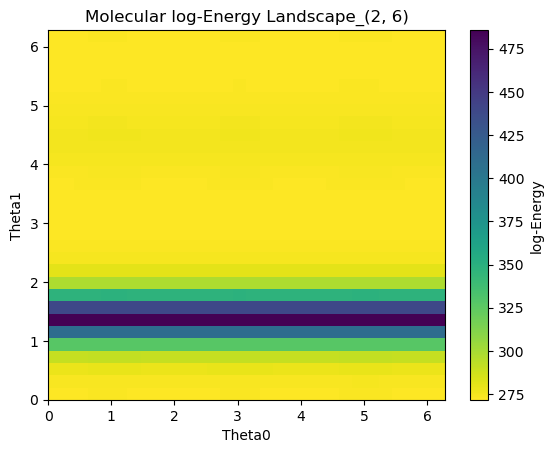

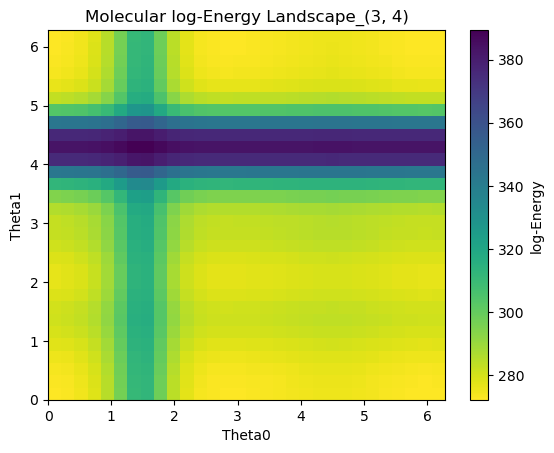

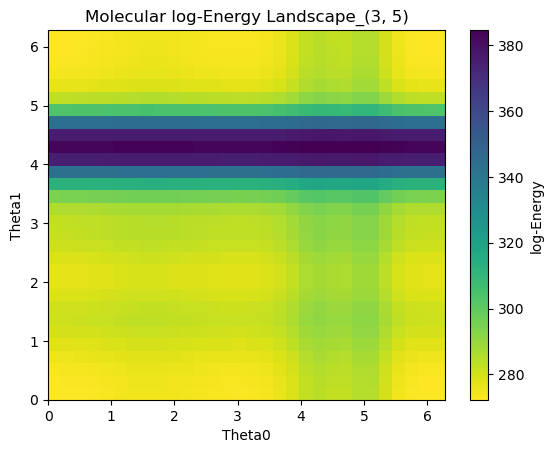

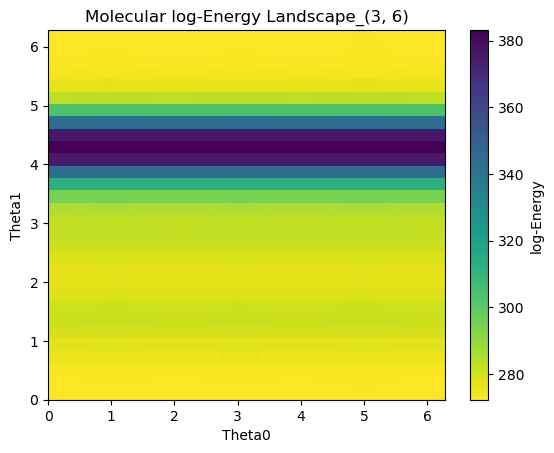

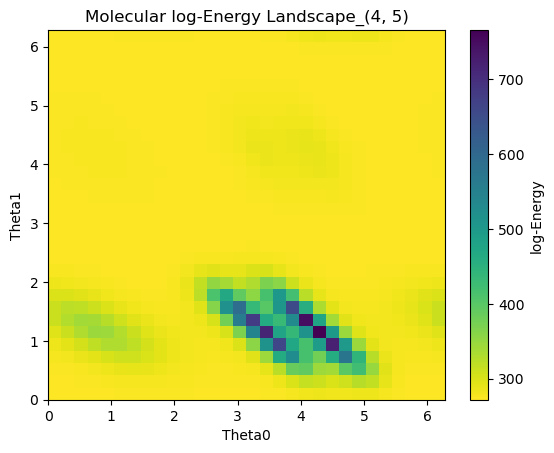

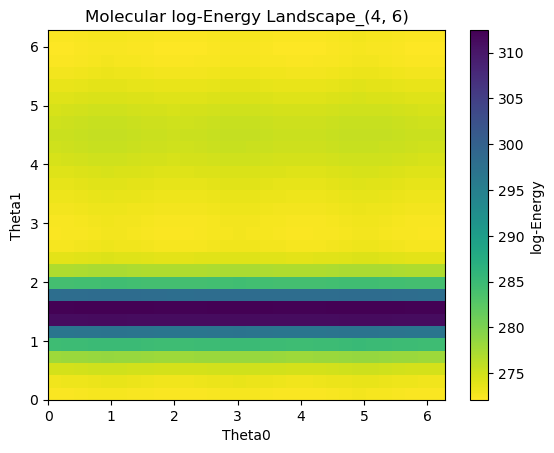

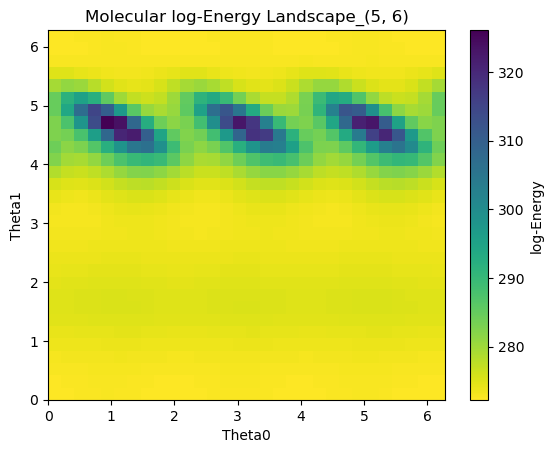

In [17]:
import itertools
ix_smi = 82
datapoint = dataset.datapoints[ix_smi]
num_torsion_angles = len(datapoint.mask_rotate)
print(f'smi: {datapoint.canonical_smi}')
data = copy.deepcopy(datapoint)
for ix in range(1): # for each different values of bond lenghts and angles from ground truth data
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    print('mmff energy optimized', 50*np.log( 100 + mmff_energy(pyg_to_mol(data.mol, data, mmff=True, rmsd=True, copy=True))))
    #print('mmff energy optimized', mmff_energy(pyg_to_mol(data.mol, data, mmff=True, rmsd=True, copy=True)))
    
    for ix0, ix1 in itertools.combinations(range(num_torsion_angles), 2):
        energy_landscape = get_2dheatmap_array(data,ix0, ix1, num_points = 30)
        #plot heatmap
        plt.figure()
        energy_landscape = np.array(energy_landscape)
        plt.imshow(50 * np.log(100 + np.array(energy_landscape) ), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
        #energy_landscape[energy_landscape>5e2] = 5e2
        #plt.imshow(np.exp(energy_landscape) , extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
        plt.colorbar(label='log-Energy')
        plt.xlabel('Theta0')
        plt.ylabel('Theta1')
        plt.title(f'Molecular log-Energy Landscape_{ix0, ix1}')
        plt.show()

In [ ]:
# An example fo a molecule for which 2 structures are very close but the energy is very different
#smile: CC(=O)Nc1ccc2c(c1)CCCC2=O 
theta0, theta1 = np.pi, np.pi 
# Update the position of data
data0 = copy.deepcopy(data)
torsion_update = np.zeros(len(data0.mask_rotate))
torsion_update[0], torsion_update[1] = theta0, theta1
new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False)
data0.pos = new_pos

plot_aligned_confs([data, data0])
# Get RMSD between data0 and data
mol0 = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
print('RMSD between data0 and data', fast_rmsd(mol0, mol, conf1=0, conf2=0))
# Get energies of mol0 and mol
print('mmff energy data0 and data', mmff_energy(mol0), mmff_energy(mol))


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RMSD between data0 and data 1.1917653672495971
mmff energy data0 and data 448.2014768936707 29.157650687347115


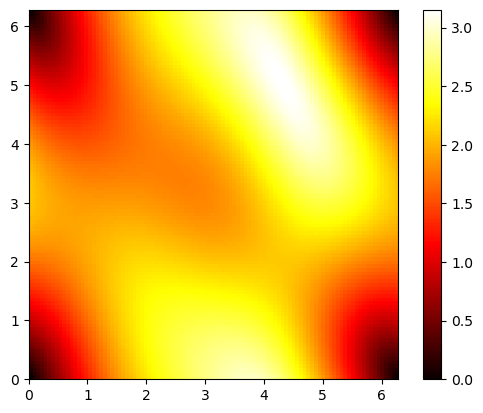

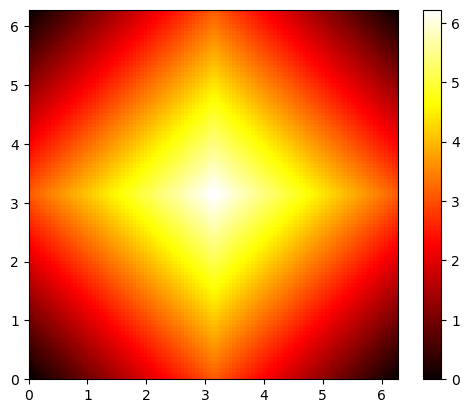

In [ ]:
dummy_data_batch = pickle.load(open('dummy_data_batch.pkl', 'rb'))
rmsds,torsion_angles_dists  = get_rmsd_torsiondist(dummy_data_batch[0] , ix0 = 0, ix1 = 1)
plt.figure()
plt.imshow(rmsds, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(torsion_angles_dists, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()

In [ ]:
from diffusion.score_model import TensorProductScoreModel
model = TensorProductScoreModel(in_node_features=74, in_edge_features=4,
                                   sigma_embed_dim=32,
                                   num_conv_layers=4,
                                   max_radius=5.0, radius_embed_dim=50,
                                   scale_by_sigma=True,
                                   use_second_order_repr=False,
                                   residual=True, batch_norm=True)
restart_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/workdir/boltz_T300'
state_dict = torch.load(f'{restart_dir}/best_model.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f'The model has {num_params} trainable parameters.')

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type anno

In [23]:
np.min(energy_landscape)

np.float64(-27.982717500739483)

## Distributional shift(ground truth vs rdkit-generated data) in bond lengths/bond angles 

In [25]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
mols = []
for ix in range(len(data.pos)):
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
    mols.append(mol)

get_stds_internal_coords(mols)

(tensor(0.0150), tensor(0.0328), tensor(1.5765))

In [9]:
mols_gen = list(conformers_gen.values())[0]
get_stds_internal_coords(mols_gen)

(tensor(0.0159), tensor(0.0701), tensor(1.5332))

In [10]:
bond_angles = [get_bond_angles(mol) for mol in mols]
bond_angles_gen = [get_bond_angles(mol)[:-1] for mol in mols_gen]
torch.stack(bond_angles + bond_angles_gen).std(dim=0).mean()

tensor(0.1286)

In [11]:
bond_lengths = [get_bond_lengths(mol) for mol in mols]
bond_lengths_gen = [get_bond_lengths(mol) for mol in mols_gen]
torch.stack(bond_lengths + bond_lengths_gen).std(dim=0).mean()

tensor(0.0986)

Hm, the std deviation of bond lengths&bond angles increases when we concatenate [mols_ground truth, mols_gen]. which seems to indicate a distributional shift in the lengths/angles distributions when we are moving from gt to rdkit-generated. Does this explain the energy-shifts?

## Making toy datasets for diffusion training

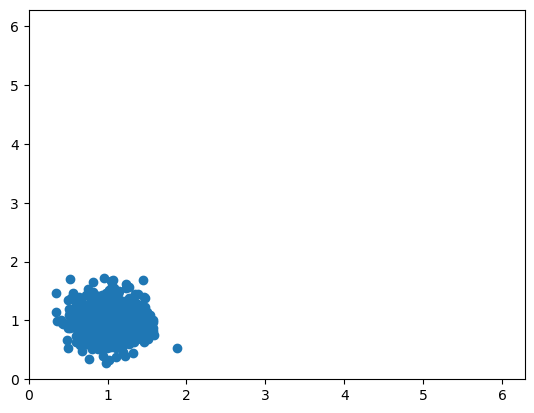

In [ ]:
mean = [1,1,1]
sigma = 0.05 
mvn = multivariate_normal(mean = mean, cov = sigma * torch.eye(len(mean)), allow_singular = False, seed = 42)
# sample from mvn
samples = mvn.rvs(1000)
#samples = np.random.multivariate_normal(mean, cov, 1000)
plt.scatter(samples[:,0], samples[:,1])
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.show()

In [7]:
def create_dummy_data(smi, dummy_data_pkl, perturbs):
    for batch_idx, batch in enumerate(tqdm.tqdm(loader, total=len(loader))):  # Here, loader is used to go through smiles. But in our case, we are going to focus only on one smiles
        assert len(batch) == 1
        if batch.canonical_smi[0] == smi:
            break 

    data = batch[0]
    assert transform == None
    data.pos = data.pos[0]
    dummy_data = []
    for perturb in perturbs:
        data0 = copy.deepcopy(data)
        new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, perturb, as_numpy=False) 
        data0.pos = new_pos
        data0.total_perturb = torch.Tensor(perturb)
        #data0.mask_rotate = torch.tensor(data0.mask_rotate)
        dummy_data.append(copy.deepcopy(data0))
    # Save the dummy data
    pickle.dump(dummy_data, open(dummy_data_pkl, 'wb'))
    return dummy_data

In [12]:
dummy_data = create_dummy_data(smi = 'Brc1cc2c(cc1Cn1c(-c3cncs3)nc3ccccc31)OCO2', dummy_data_pkl = 'dummy_data_gaussian.pkl', perturbs = samples)

  0%|          | 1/9295 [00:00<01:13, 126.23it/s]

In [13]:
plot_aligned_confs(dummy_data)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

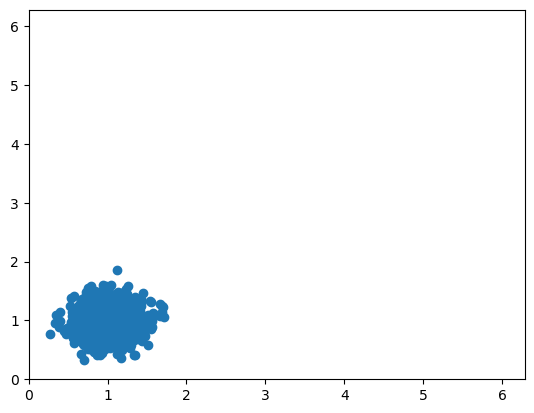

In [15]:
dummy_data_pkl, ix0, ix1 = 'dummy_data_gaussian.pkl', 0, 1
dummy_data = pickle.load(open(dummy_data_pkl, 'rb'))
smi = dummy_data[0].canonical_smi

total_perturbs = Batch.from_data_list(dummy_data).total_perturb.reshape(-1, 3)
plt.scatter(total_perturbs[:,1], total_perturbs[:,2])
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.show()

## Function that needs to be parallelized 

In [8]:
import torch 
import numpy as np
import copy
from scipy.spatial.transform import Rotation as R

In [9]:
def modify_conformer(pos_input, edge_index, mask_rotate, torsion_updates_input, as_numpy=False):
    '''
    Modifies the conformer's 3D coordinates based on the torsion updates.
    Args:
        pos_input: (N, 3) tensor of 3D coordinates
        edge_index: (E, 2) tensor of edge indices
        mask_rotate: (E, N) tensor of boolean masks indicating which atoms are rotated by each edge
        torsion_updates_input: (K,) tensor of torsion updates
        as_numpy: whether to return the output as a numpy array
    Returns:
        pos: (N, 3) tensor of modified 3D coordinates
    '''
    pos = copy.deepcopy(pos_input)
    if type(pos) != np.ndarray: pos = pos.cpu().numpy()
    if type(torsion_updates_input) != np.ndarray: 
        torsion_updates = copy.deepcopy(torsion_updates_input.detach()).cpu().numpy()
    else:
        torsion_updates = torsion_updates_input
    for idx_edge, e in enumerate(edge_index.cpu().numpy()):
        if torsion_updates[idx_edge] == 0:
            continue
        u, v = int(e[0]), int(e[1])

        # check if need to reverse the edge, v should be connected to the part that gets rotated
        assert not mask_rotate[idx_edge, u] or not mask_rotate[idx_edge, u.item()]
        assert mask_rotate[idx_edge, v]

        rot_vec = pos[u] - pos[v] # convention: positive rotation if pointing inwards. NOTE: DIFFERENT FROM THE PAPER!
        rot_vec = rot_vec * torsion_updates[idx_edge] / np.linalg.norm(rot_vec) # idx_edge!
        rot_mat = R.from_rotvec(rot_vec).as_matrix()

        pos[mask_rotate[idx_edge]] = (pos[mask_rotate[idx_edge]] - pos[v]) @ rot_mat.T + pos[v]

    if not as_numpy: pos = torch.from_numpy(pos.astype(np.float32))
    return pos

In [16]:
pos_input = torch.Tensor([[-2.4816,  0.4621, -0.0431],
        [-1.6341, -1.2250, -0.0677],
        [-0.4341, -1.3996, -0.6324],
        [ 0.0653, -2.7274, -0.6143],
        [-0.5959, -3.7824, -0.0696],
        [-1.8320, -3.5810,  0.5093],
        [-2.3478, -2.3003,  0.5082],
        [-3.3011, -2.1072,  0.9473],
        [-2.3012, -4.8075,  0.9934],
        [-1.5430, -5.8271,  0.3678],
        [-0.3348, -5.1506,  0.0761],
        [-2.0349, -6.0840, -0.5935],
        [-1.3852, -6.7025,  1.0297],
        [ 1.0249, -2.9138, -1.0583],
        [ 0.4228, -0.3848, -1.2090],
        [ 1.6921, -0.1238, -0.6248],
        [ 2.7165, -1.0341, -0.5894],
        [ 2.9031, -2.3065, -1.0737],
        [ 4.0671, -3.0228, -0.8909],
        [ 5.1118, -2.4565, -0.1899],
        [ 4.9508, -1.1830,  0.3064],
        [ 3.7548, -0.4785,  0.1045],
        [ 3.3412,  0.7348,  0.4714],
        [ 2.0752,  0.9637,  0.0330],
        [ 1.3364,  2.2032,  0.3775],
        [ 1.8716,  3.4326,  0.6637],
        [ 1.0607,  4.3791,  1.0006],
        [-0.2420,  4.1424,  1.0598],
        [-0.3250,  2.4963,  0.6162],
        [-1.0430,  4.8552,  1.3315],
        [ 2.9710,  3.5967,  0.6027],
        [ 5.7457, -0.7001,  0.8632],
        [ 6.0342, -3.0124, -0.0396],
        [ 4.2095, -4.0232, -1.2741],
        [ 2.1060, -2.7773, -1.6202],
        [ 0.5136, -0.5947, -2.3265],
        [-0.1138,  0.6163, -1.2253]])


edge_index = torch.Tensor([[14,  2],
        [15, 14],
        [23, 24]])

mask_rotate = np.array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False]])

torsion_updates_input = np.array([ 0.77378716, -0.15896694,  1.56961906])

modify_conformer(pos_input, edge_index, mask_rotate, torsion_updates_input, as_numpy=False)

tensor([[-1.1387,  0.7159,  1.4106],
        [-1.2065, -0.9821,  0.5876],
        [-0.5141, -1.2512, -0.5248],
        [-0.6904, -2.5544, -1.0573],
        [-1.4973, -3.4992, -0.5068],
        [-2.2020, -3.2023,  0.6416],
        [-2.0538, -1.9421,  1.1859],
        [-2.5831, -1.6773,  2.0739],
        [-2.9510, -4.3267,  1.0068],
        [-3.0172, -5.1764, -0.1244],
        [-1.8388, -4.8203, -0.8222],
        [-3.8884, -4.8673, -0.7390],
        [-3.0329, -6.2495,  0.1538],
        [-0.1547, -2.8132, -1.9510],
        [ 0.4228, -0.3848, -1.2090],
        [ 1.6921, -0.1238, -0.6248],
        [ 2.7165, -1.0341, -0.5894],
        [ 2.9031, -2.3065, -1.0737],
        [ 4.0671, -3.0228, -0.8909],
        [ 5.1118, -2.4565, -0.1899],
        [ 4.9508, -1.1830,  0.3064],
        [ 3.7548, -0.4785,  0.1045],
        [ 3.3412,  0.7348,  0.4714],
        [ 2.0752,  0.9637,  0.0330],
        [ 1.3364,  2.2032,  0.3775],
        [ 0.9720,  2.6281,  1.6291],
        [ 0.2762,  3.7120,  1.7186],
 

## Debug Code

In [ ]:
conformers_train_gen = pickle.load(open('conformers_train_gen_on_policy.pkl', 'rb'))
dummy_data_batch = pickle.load(open('dummy_data_batch_diffusion.pkl', 'rb'))

Batch.from_data_list(conformers_train_gen).total_perturb.reshape(-1,3).mean(dim=0)

Batch.from_data_list(dummy_data_batch).total_perturb.reshape(-1,3)

plot_aligned_confs(conformers_train_gen)

plot_aligned_confs([conformers_train_gen[5], dummy_data_batch[0]])

gt_mols = [pyg_to_mol(dummy_data_batch[i].mol, dummy_data_batch[i], copy=True) for i in range(len(dummy_data_batch))]
gen_mols = [pyg_to_mol(conformers_train_gen[i].mol, conformers_train_gen[i], copy=True) for i in range(len(conformers_train_gen))]
rmsds = np.array([get_rmsds([gt_mols[i] for _ in range(len(gen_mols))], gen_mols) for i in range(len(gt_mols))])
rmsds = np.min(rmsds, axis=0)

get_rmsds(gt_mols, [gen_mols[5] for _ in range(len(gt_mols))])

## Test for xtb energy code (both code in torsional_diff repo and Sasha's code)

In [8]:
data = next(iter(loader))
data

DataBatch(x=[32, 74], edge_index=[2, 70], edge_attr=[70, 4], z=[32], canonical_smi=[1], mol=[1], pos=[30], weights=[1], edge_mask=[70], mask_rotate=[1], batch=[32], ptr=[2])

In [15]:
from utils.xtb import xtb_energy

for i in range(len(data[0].pos)):
    data0 = copy.deepcopy(data[0])
    data0.pos = data[0].pos[i]
    mol = pyg_to_mol(data0.mol, data0, copy=True)
    print(f'Energy {i} {xtb_energy(mol, path_xtb = "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/xtb" )}')

xtb_energy did not converge
Energy 0 {}
xtb_energy did not converge
Energy 1 {}
xtb_energy did not converge
Energy 2 {}
xtb_energy did not converge
Energy 3 {}
xtb_energy did not converge
Energy 4 {}
xtb_energy did not converge
Energy 5 {}
xtb_energy did not converge
Energy 6 {}
xtb_energy did not converge
Energy 7 {}
xtb_energy did not converge
Energy 8 {}
xtb_energy did not converge
Energy 9 {}
xtb_energy did not converge
Energy 10 {}
xtb_energy did not converge
Energy 11 {}
xtb_energy did not converge
Energy 12 {}
xtb_energy did not converge
Energy 13 {}
xtb_energy did not converge
Energy 14 {}
xtb_energy did not converge
Energy 15 {}
xtb_energy did not converge
Energy 16 {}
xtb_energy did not converge
Energy 17 {}
xtb_energy did not converge
Energy 18 {}
xtb_energy did not converge
Energy 19 {}
xtb_energy did not converge
Energy 20 {}
xtb_energy did not converge
Energy 21 {}
xtb_energy did not converge
Energy 22 {}
xtb_energy did not converge
Energy 23 {}
xtb_energy did not converg

In [9]:
import contextlib
import os
import re
import subprocess
import warnings

import numpy as np


def _get_energy(file):
    normal_termination = False
    with open(file) as f:
        for l in f:
            if "TOTAL ENERGY" in l:
                try:
                    energy = float(re.search(r"[+-]?(?:\d*\.)?\d+", l).group())
                except:
                    return np.nan
            if "normal termination of xtb" in l:
                normal_termination = True
    if normal_termination:
        return energy
    else:
        return np.nan


def run_gfn_xtb(
    filepath,
    filename,
    gfn_version="gfnff",
    opt=False,
    gfn_xtb_config: str = None,
    remove_scratch=True,
):
    """
    Runs GFN_XTB/FF given a directory and either a coord file or all coord files will be run

    :param filepath: Directory containing the coord file
    :param filename: if given, the specific coord file to run
    :param gfn_version: GFN_xtb version (default is 2)
    :param opt: optimization or single point (default is opt)
    :param gfn_xtb_config: additional xtb config (default is None)
    :param remove_scratch: remove xtb files
    :return:
    """
    xyz_file = os.path.join(filepath, filename)

    # optimization vs single point
    if opt:
        opt = "--opt"
    else:
        opt = ""

    # cd to filepath
    starting_dir = os.getcwd()
    os.chdir(filepath)

    file_name = str(xyz_file.split(".")[0])
    cmd = "xtb --{} {} {} {}".format(
        str(gfn_version), xyz_file, opt, str(gfn_xtb_config or "")
    )

    # run XTB
    with open(file_name + ".out", "w") as fd:
        subprocess.run(cmd, shell=True, stdout=fd, stderr=subprocess.STDOUT)

    # check XTB results
    if os.path.isfile(os.path.join(filepath, "NOT_CONVERGED")):
        # optimization not converged
        warnings.warn(
            "xtb --{} for {} is not converged, using last optimized step instead; proceed with caution".format(
                str(gfn_version), file_name
            )
        )

        # remove files
        if remove_scratch:
            os.remove(os.path.join(filepath, "NOT_CONVERGED"))
            os.remove(os.path.join(filepath, "xtblast.xyz"))
            os.remove(os.path.join(filepath, file_name + ".out"))
        energy = np.nan

    elif opt and not os.path.isfile(os.path.join(filepath, "xtbopt.xyz")):
        # other abnormal optimization convergence
        warnings.warn(
            "xtb --{} for {} abnormal termination, likely scf issues, using initial geometry instead; proceed with caution".format(
                str(gfn_version), file_name
            )
        )
        if remove_scratch:
            os.remove(os.path.join(filepath, file_name + ".out"))
        energy = np.nan

    else:
        # normal convergence
        # get energy
        energy = _get_energy(file_name + ".out")
        if remove_scratch:
            with contextlib.suppress(FileNotFoundError):
                os.remove(os.path.join(filepath, file_name + ".out"))
                os.remove(os.path.join(filepath, "gfnff_charges"))
                os.remove(os.path.join(filepath, "gfnff_adjacency"))
                os.remove(os.path.join(filepath, "gfnff_topo"))
                os.remove(os.path.join(filepath, "xtbopt.log"))
                os.remove(os.path.join(filepath, "xtbopt.xyz"))
                os.remove(os.path.join(filepath, "xtbtopo.mol"))
                os.remove(os.path.join(filepath, "wbo"))
                os.remove(os.path.join(filepath, "charges"))
                os.remove(os.path.join(filepath, "xtbrestart"))
    os.chdir(starting_dir)
    return energy

In [10]:
import numpy as np
import numpy.typing as npt
import torch
from joblib import Parallel, delayed
from torch import Tensor
from wurlitzer import pipes
from tempfile import TemporaryDirectory
from pathlib import Path

def _write_xyz_file(
    elements: npt.NDArray, coordinates: npt.NDArray, file_path: str
) -> None:
    num_atoms = len(elements)
    with open(file_path, "w") as f:
        f.write(str(num_atoms) + "\n")
        f.write("\n")

        for i in range(num_atoms):
            element = elements[i]
            x, y, z = coordinates[i]
            line = f"{int(element)} {x:.6f} {y:.6f} {z:.6f}\n"
            f.write(line)


def get_energy(numbers, positions, method="gfnff"):
    directory = TemporaryDirectory()
    file_name = "input.xyz"

    _write_xyz_file(numbers, positions, str(Path(directory.name) / "input.xyz"))
    with pipes():
        energy = run_gfn_xtb(directory.name, file_name, gfn_version=method)
    directory.cleanup()

    if np.isnan(energy):
        return 0.0

    return energy

In [17]:
numbers = np.array(data.z )
for i in range(len(data.pos)):
    positions = data.pos[i].cpu().numpy() * 1.88973 # Convert angstrom to bohr
    print('xtb energy', get_energy(numbers, positions, method="gfnff"))
    # Get mmff energy
    data0 = copy.deepcopy(data[0])
    data0.pos = data.pos[i]
    mol = pyg_to_mol(data0.mol, data0, copy=True)
    print('mmff energy', mmff_energy(mol))

xtb energy 0.0
mmff energy 121.3116009195142
xtb energy 0.0
mmff energy 122.86134879363988


xtb energy 0.0
mmff energy 161.6486340640398
xtb energy 0.0
mmff energy 125.2604098036516
xtb energy 0.0
mmff energy 128.70566894271877
xtb energy 0.0
mmff energy 153.76089445331627
xtb energy 0.0
mmff energy 332.43989204944984
xtb energy 0.0
mmff energy 121.47693468083162
xtb energy 0.0
mmff energy 144.12324823583413
xtb energy 0.0
mmff energy 124.45701224428865
xtb energy 0.0
mmff energy 132.8055856825035
xtb energy 0.0
mmff energy 132.43307647931928
xtb energy 0.0
mmff energy 141.5042334805122
xtb energy 0.0
mmff energy 127.24921893627723
xtb energy 0.0
mmff energy 129.14555094835276
xtb energy 0.0
mmff energy 141.03716623299175
xtb energy 0.0
mmff energy 153.13854042078646
xtb energy 0.0
mmff energy 153.08036970382176
xtb energy 0.0
mmff energy 135.37674077455193
xtb energy 0.0
mmff energy 134.6181202849798
xtb energy 0.0
mmff energy 141.6416562461666
xtb energy 0.0
mmff energy 130.88865207375883
xtb energy 0.0
mmff energy 160.87546824245996
xtb energy 0.0
mmff energy 129.102265614

min energy landscape 122.19796703374843


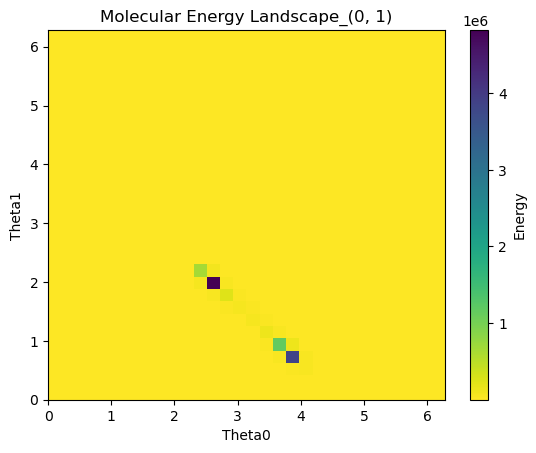

In [23]:
energy_landscape = get_2dheatmap_array(data0,ix0=0, ix1=1, num_points=30)
print('min energy landscape', np.array(energy_landscape).min())
plt.figure()
plt.imshow(energy_landscape , extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
plt.colorbar(label='Energy')
plt.xlabel('Theta0')
plt.ylabel('Theta1')
plt.title(f'Molecular Energy Landscape_{0, 1}')
plt.show()